In [24]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [25]:
import pathlib

dataset_dir = "../keepfit/finalize-training-dataset/"
# dataset_dir = "../keepfit/small-training-img-dataset/"
data_dir = pathlib.Path(dataset_dir).with_suffix('')
data_dir

PosixPath('../keepfit/finalize-training-dataset')

In [26]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

863


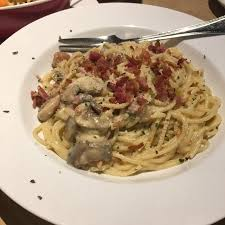

In [27]:
carbonara = list(data_dir.glob('carbonara/*'))
PIL.Image.open(str(carbonara[0]))

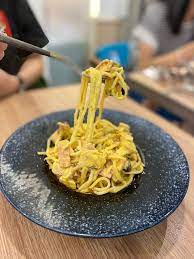

In [28]:
PIL.Image.open(str(carbonara[1]))

In [29]:
batch_size = 32
img_height = 180
img_width = 180

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 863 files belonging to 3 classes.


Using 691 files for training.


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 863 files belonging to 3 classes.
Using 172 files for validation.


In [32]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['alldaybreakfast', 'carbonara', 'steak']


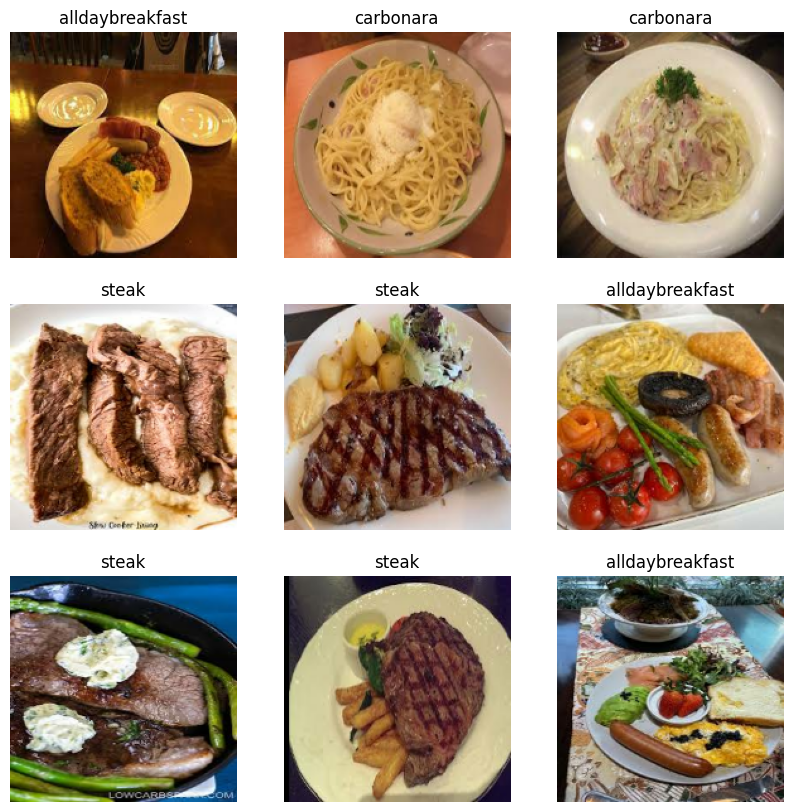

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
normalization_layer = layers.Rescaling(1./255)

In [37]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99497217


In [38]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2023-09-18 10:27:17.870483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:18.017062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:18.066522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:18.116977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:18.183619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:18.236445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

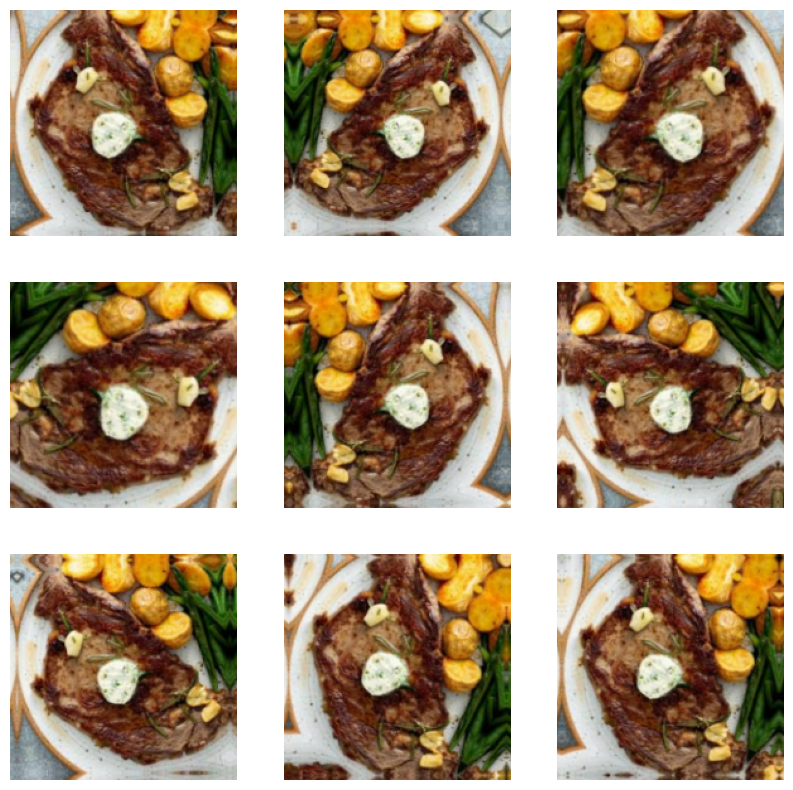

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [40]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [43]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2023-09-18 10:27:19.416140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 10:27:19.555778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/22 [===>..........................] - ETA: 1s - loss: 3.0676 - accuracy: 0.4375

2023-09-18 10:27:19.907557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:19.977571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.070030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 1s - loss: 2.3541 - accuracy: 0.3750

2023-09-18 10:27:20.132957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.196621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.266111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.328713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/22 [==============>...............] - ETA: 0s - loss: 1.9233 - accuracy: 0.3722

2023-09-18 10:27:20.389606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.446360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.519478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/22 [==================>...........] - ETA: 0s - loss: 1.7241 - accuracy: 0.3661

2023-09-18 10:27:20.594955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.658848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.720674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.781058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/22 [======================>.......] - ETA: 0s - loss: 1.6175 - accuracy: 0.3915

2023-09-18 10:27:20.844793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.902424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:20.986656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/22 [==========================>...] - ETA: 0s - loss: 1.5435 - accuracy: 0.3907

2023-09-18 10:27:21.214201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:21.313216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:21.379443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.3980

2023-09-18 10:27:21.460206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:21.950165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 3s 109ms/step - loss: 1.4974 - accuracy: 0.3980 - val_loss: 1.0566 - val_accuracy: 0.4419
Epoch 2/15
 1/22 [>.............................] - ETA: 2s - loss: 1.0856 - accuracy: 0.3158

2023-09-18 10:27:22.201089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:22.331782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/22 [====>.........................] - ETA: 1s - loss: 1.0621 - accuracy: 0.4261

2023-09-18 10:27:22.445040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:22.531164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:22.594681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/22 [=========>....................] - ETA: 1s - loss: 1.0109 - accuracy: 0.4650

2023-09-18 10:27:22.654571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:22.716108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:22.775993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:22.841106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/22 [===============>..............] - ETA: 0s - loss: 0.9971 - accuracy: 0.4663

2023-09-18 10:27:22.907589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:22.969762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.043878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/22 [===================>..........] - ETA: 0s - loss: 0.9907 - accuracy: 0.4732

2023-09-18 10:27:23.108229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.167983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.232982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.298118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/22 [=======================>......] - ETA: 0s - loss: 0.9875 - accuracy: 0.4778

2023-09-18 10:27:23.359029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.436727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.504522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.9684 - accuracy: 0.4790

2023-09-18 10:27:23.566152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.625057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.684161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 72ms/step - loss: 0.9684 - accuracy: 0.4790 - val_loss: 0.9521 - val_accuracy: 0.4535
Epoch 3/15
 2/22 [=>............................] - ETA: 1s - loss: 0.8541 - accuracy: 0.5469

2023-09-18 10:27:23.839579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.901576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:23.991510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/22 [=======>......................] - ETA: 1s - loss: 0.7706 - accuracy: 0.6354

2023-09-18 10:27:24.072052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.142103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.210146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/22 [===========>..................] - ETA: 0s - loss: 0.7774 - accuracy: 0.6215

2023-09-18 10:27:24.273509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.335761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.399717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.464883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/22 [================>.............] - ETA: 0s - loss: 0.7594 - accuracy: 0.6370

2023-09-18 10:27:24.526930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.585232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.657764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.721896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/22 [======================>.......] - ETA: 0s - loss: 0.7390 - accuracy: 0.6599

2023-09-18 10:27:24.799516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.866562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.926556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:24.987081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/22 [==========================>...] - ETA: 0s - loss: 0.7469 - accuracy: 0.6507

2023-09-18 10:27:25.056583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:25.120851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.6541

2023-09-18 10:27:25.259052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:25.325571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 75ms/step - loss: 0.7503 - accuracy: 0.6541 - val_loss: 0.8164 - val_accuracy: 0.6279
Epoch 4/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.6940 - accuracy: 0.7083

2023-09-18 10:27:25.484248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:25.556534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:25.621012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/22 [=====>........................] - ETA: 1s - loss: 0.6929 - accuracy: 0.7063

2023-09-18 10:27:25.687875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:25.748674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:25.834452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/22 [===========>..................] - ETA: 0s - loss: 0.7174 - accuracy: 0.7222

2023-09-18 10:27:25.896924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:25.956131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.016470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.075816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/22 [================>.............] - ETA: 0s - loss: 0.7147 - accuracy: 0.7171

2023-09-18 10:27:26.148271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.199618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.262907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.328447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/22 [======================>.......] - ETA: 0s - loss: 0.6820 - accuracy: 0.7288

2023-09-18 10:27:26.391261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.452453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.517814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.578268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/22 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.7390

2023-09-18 10:27:26.637175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.702028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.763044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:26.825725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 1s 67ms/step - loss: 0.6600 - accuracy: 0.7381 - val_loss: 0.5710 - val_accuracy: 0.7791
Epoch 5/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.5794 - accuracy: 0.7708

2023-09-18 10:27:26.966153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.028357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.086769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.145013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 0s - loss: 0.5616 - accuracy: 0.7634

2023-09-18 10:27:27.221951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.291025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.358408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/22 [=========>....................] - ETA: 0s - loss: 0.5376 - accuracy: 0.7734

2023-09-18 10:27:27.424781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.495029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/22 [===============>..............] - ETA: 0s - loss: 0.5517 - accuracy: 0.7760

2023-09-18 10:27:27.650450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.723456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.784757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:27.845682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/22 [===================>..........] - ETA: 0s - loss: 0.5733 - accuracy: 0.7709

2023-09-18 10:27:27.984438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.056986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.126015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/22 [========================>.....] - ETA: 0s - loss: 0.5573 - accuracy: 0.7748

2023-09-18 10:27:28.197780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.264039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.329292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/22 [===========================>..] - ETA: 0s - loss: 0.5570 - accuracy: 0.7754

2023-09-18 10:27:28.413190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.513124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.600667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 84ms/step - loss: 0.5618 - accuracy: 0.7728 - val_loss: 0.9142 - val_accuracy: 0.6453
Epoch 6/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.5352 - accuracy: 0.7708

2023-09-18 10:27:28.790162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.864929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:28.927032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/22 [=====>........................] - ETA: 1s - loss: 0.5609 - accuracy: 0.7812

2023-09-18 10:27:28.994288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.056263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.130885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/22 [=========>....................] - ETA: 0s - loss: 0.5114 - accuracy: 0.7969

2023-09-18 10:27:29.202857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.285373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.349760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/22 [===============>..............] - ETA: 0s - loss: 0.5580 - accuracy: 0.7786

2023-09-18 10:27:29.426596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.492829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.554488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.614662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/22 [====================>.........] - ETA: 0s - loss: 0.5715 - accuracy: 0.7656

2023-09-18 10:27:29.676977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.736472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.802747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:29.866049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/22 [========================>.....] - ETA: 0s - loss: 0.5731 - accuracy: 0.7613

2023-09-18 10:27:29.930349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.035830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.102437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7424

2023-09-18 10:27:30.166200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.234482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 72ms/step - loss: 0.6131 - accuracy: 0.7424 - val_loss: 0.6405 - val_accuracy: 0.7035
Epoch 7/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.7009 - accuracy: 0.6979

2023-09-18 10:27:30.377286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.445287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.518127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/22 [=======>......................] - ETA: 1s - loss: 0.6969 - accuracy: 0.6816

2023-09-18 10:27:30.585138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.644665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.689935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.760261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/22 [============>.................] - ETA: 0s - loss: 0.6661 - accuracy: 0.6971

2023-09-18 10:27:30.828373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.889910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:30.966157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/22 [================>.............] - ETA: 0s - loss: 0.6383 - accuracy: 0.7171

2023-09-18 10:27:31.030533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.091839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.157329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.219089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/22 [======================>.......] - ETA: 0s - loss: 0.6179 - accuracy: 0.7345

2023-09-18 10:27:31.281622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.352695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.425490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/22 [==========================>...] - ETA: 0s - loss: 0.6038 - accuracy: 0.7432

2023-09-18 10:27:31.485895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.557999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.620015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.682430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 69ms/step - loss: 0.5881 - accuracy: 0.7453 - val_loss: 0.8194 - val_accuracy: 0.6105
Epoch 8/15


2023-09-18 10:27:31.756660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:31.905112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/22 [====>.........................] - ETA: 1s - loss: 0.5457 - accuracy: 0.7812

2023-09-18 10:27:31.977125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.037708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.096066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.156050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/22 [=========>....................] - ETA: 0s - loss: 0.5329 - accuracy: 0.7852

2023-09-18 10:27:32.216813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.279940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.342113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.401258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/22 [===============>..............] - ETA: 0s - loss: 0.5250 - accuracy: 0.7943

2023-09-18 10:27:32.459942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.521884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.593763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.651965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/22 [====================>.........] - ETA: 0s - loss: 0.5119 - accuracy: 0.8027

2023-09-18 10:27:32.710992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.768159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.829692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:32.889766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/22 [========================>.....] - ETA: 0s - loss: 0.5181 - accuracy: 0.7950

2023-09-18 10:27:32.954167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.003730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.077332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.5359 - accuracy: 0.7902

2023-09-18 10:27:33.210857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.301423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 70ms/step - loss: 0.5359 - accuracy: 0.7902 - val_loss: 0.4900 - val_accuracy: 0.7965
Epoch 9/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.4272 - accuracy: 0.8333

2023-09-18 10:27:33.453002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.523794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.585712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.646889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/22 [=======>......................] - ETA: 1s - loss: 0.4534 - accuracy: 0.8073

2023-09-18 10:27:33.709035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.771816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.844861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/22 [============>.................] - ETA: 0s - loss: 0.5049 - accuracy: 0.7883

2023-09-18 10:27:33.940327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:33.999382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.068870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.121699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/22 [==================>...........] - ETA: 0s - loss: 0.5178 - accuracy: 0.7793

2023-09-18 10:27:34.194272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.253413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.314031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.374463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/22 [=======================>......] - ETA: 0s - loss: 0.4959 - accuracy: 0.7957

2023-09-18 10:27:34.433120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.501298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.567990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.627105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.7988

2023-09-18 10:27:34.689326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.750408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:34.807813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 1s 68ms/step - loss: 0.4867 - accuracy: 0.7988 - val_loss: 0.5908 - val_accuracy: 0.7616
Epoch 10/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.3774 - accuracy: 0.8333

2023-09-18 10:27:34.946291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.001808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.066605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.131242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 0s - loss: 0.4019 - accuracy: 0.8348

2023-09-18 10:27:35.208818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.274596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.334997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.404132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/22 [==============>...............] - ETA: 0s - loss: 0.4141 - accuracy: 0.8494

2023-09-18 10:27:35.466699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.525980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.600854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.661410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/22 [===================>..........] - ETA: 0s - loss: 0.4176 - accuracy: 0.8438

2023-09-18 10:27:35.724588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.798578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.859910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:35.920209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/22 [=======================>......] - ETA: 0s - loss: 0.4202 - accuracy: 0.8438

2023-09-18 10:27:35.981317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.043757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.160590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8336

2023-09-18 10:27:36.266517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.327080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.407980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 73ms/step - loss: 0.4411 - accuracy: 0.8336 - val_loss: 0.5816 - val_accuracy: 0.7791
Epoch 11/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.3509 - accuracy: 0.8646

2023-09-18 10:27:36.549264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.616800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.682302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.741058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 0s - loss: 0.4196 - accuracy: 0.8527

2023-09-18 10:27:36.808197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.875294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:36.940145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.000196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/22 [==============>...............] - ETA: 0s - loss: 0.4282 - accuracy: 0.8523

2023-09-18 10:27:37.059291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.123874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.188367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.255758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/22 [===================>..........] - ETA: 0s - loss: 0.4203 - accuracy: 0.8500

2023-09-18 10:27:37.317709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.393876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.455087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.516158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/22 [========================>.....] - ETA: 0s - loss: 0.4162 - accuracy: 0.8555

2023-09-18 10:27:37.574972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.634906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.697023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.757624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 1s 67ms/step - loss: 0.4216 - accuracy: 0.8466 - val_loss: 0.5204 - val_accuracy: 0.8023
Epoch 12/15


2023-09-18 10:27:37.819854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:37.879881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.019695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/22 [====>.........................] - ETA: 1s - loss: 0.4200 - accuracy: 0.8281

2023-09-18 10:27:38.078883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.137413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.202610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.262818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 1s - loss: 0.4164 - accuracy: 0.8348

2023-09-18 10:27:38.330752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.446296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.518359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/22 [==============>...............] - ETA: 0s - loss: 0.4313 - accuracy: 0.8348

2023-09-18 10:27:38.576402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.630445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.690683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.758718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/22 [==================>...........] - ETA: 0s - loss: 0.4324 - accuracy: 0.8345

2023-09-18 10:27:38.816573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.884400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:38.996009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/22 [====================>.........] - ETA: 0s - loss: 0.4448 - accuracy: 0.8236

2023-09-18 10:27:39.070280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:39.133225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/22 [========================>.....] - ETA: 0s - loss: 0.4197 - accuracy: 0.8353

2023-09-18 10:27:39.318906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:39.412882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:39.487631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.8292

2023-09-18 10:27:39.559242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:39.622899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 81ms/step - loss: 0.4238 - accuracy: 0.8292 - val_loss: 0.6873 - val_accuracy: 0.7500
Epoch 13/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.2963 - accuracy: 0.8854

2023-09-18 10:27:39.774627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:39.840056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:39.898582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:39.960118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 0s - loss: 0.3866 - accuracy: 0.8304

2023-09-18 10:27:40.019018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.083938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.152826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/22 [============>.................] - ETA: 0s - loss: 0.3698 - accuracy: 0.8406

2023-09-18 10:27:40.224966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.288489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.352423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.415197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/22 [================>.............] - ETA: 0s - loss: 0.3705 - accuracy: 0.8462

2023-09-18 10:27:40.488263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.565991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.635956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/22 [======================>.......] - ETA: 0s - loss: 0.3765 - accuracy: 0.8475

2023-09-18 10:27:40.698160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.765608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.837196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:40.897589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/22 [==========================>...] - ETA: 0s - loss: 0.3783 - accuracy: 0.8405

2023-09-18 10:27:40.958009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.033705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.099109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 72ms/step - loss: 0.3847 - accuracy: 0.8408 - val_loss: 0.5112 - val_accuracy: 0.8140
Epoch 14/15


2023-09-18 10:27:41.170243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.351099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/22 [===>..........................] - ETA: 1s - loss: 0.5260 - accuracy: 0.8125

2023-09-18 10:27:41.434083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.507252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.584375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 1s - loss: 0.4576 - accuracy: 0.8214

2023-09-18 10:27:41.645464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.710001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.774518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.843119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/22 [==============>...............] - ETA: 0s - loss: 0.4337 - accuracy: 0.8289

2023-09-18 10:27:41.903360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:41.967254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.032987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.094264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/22 [===================>..........] - ETA: 0s - loss: 0.4338 - accuracy: 0.8330

2023-09-18 10:27:42.177535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.240495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.309564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.373345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/22 [========================>.....] - ETA: 0s - loss: 0.4243 - accuracy: 0.8319

2023-09-18 10:27:42.433174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.497610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.567829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.628802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8437

2023-09-18 10:27:42.695306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.757786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 70ms/step - loss: 0.3982 - accuracy: 0.8437 - val_loss: 0.6210 - val_accuracy: 0.7616
Epoch 15/15
 3/22 [===>..........................] - ETA: 1s - loss: 0.2724 - accuracy: 0.8795

2023-09-18 10:27:42.911344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:42.973013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.021118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.090820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/22 [========>.....................] - ETA: 0s - loss: 0.2835 - accuracy: 0.8815

2023-09-18 10:27:43.162665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.227073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.293441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/22 [===========>..................] - ETA: 0s - loss: 0.3101 - accuracy: 0.8655

2023-09-18 10:27:43.366343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.458838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.525991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/22 [================>.............] - ETA: 0s - loss: 0.3031 - accuracy: 0.8610

2023-09-18 10:27:43.592531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.650301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.719586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.784518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/22 [======================>.......] - ETA: 0s - loss: 0.3554 - accuracy: 0.8437

2023-09-18 10:27:43.857786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.920256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:43.983915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:44.052594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/22 [===========================>..] - ETA: 0s - loss: 0.3421 - accuracy: 0.8498

2023-09-18 10:27:44.118588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:44.184206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:44.248414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-18 10:27:44.313313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/22 [==============================] - 2s 72ms/step - loss: 0.3396 - accuracy: 0.8509 - val_loss: 0.5909 - val_accuracy: 0.7500


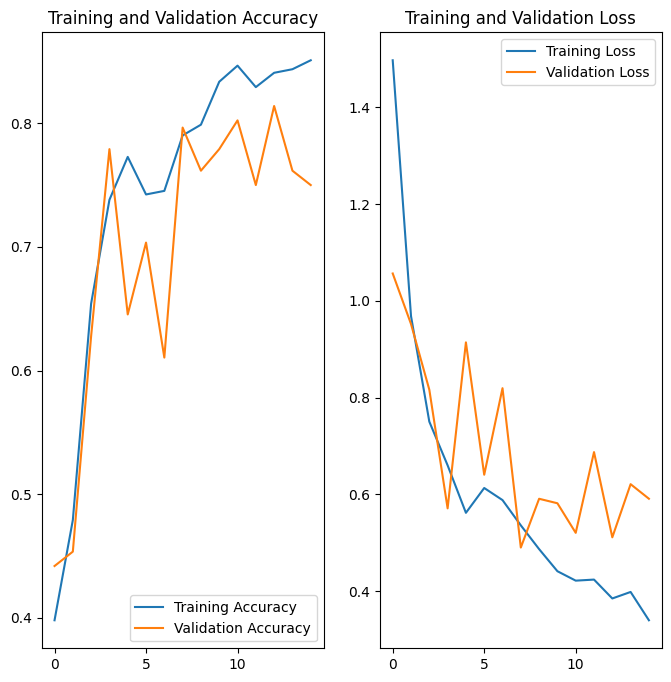

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
import matplotlib.pyplot as plt

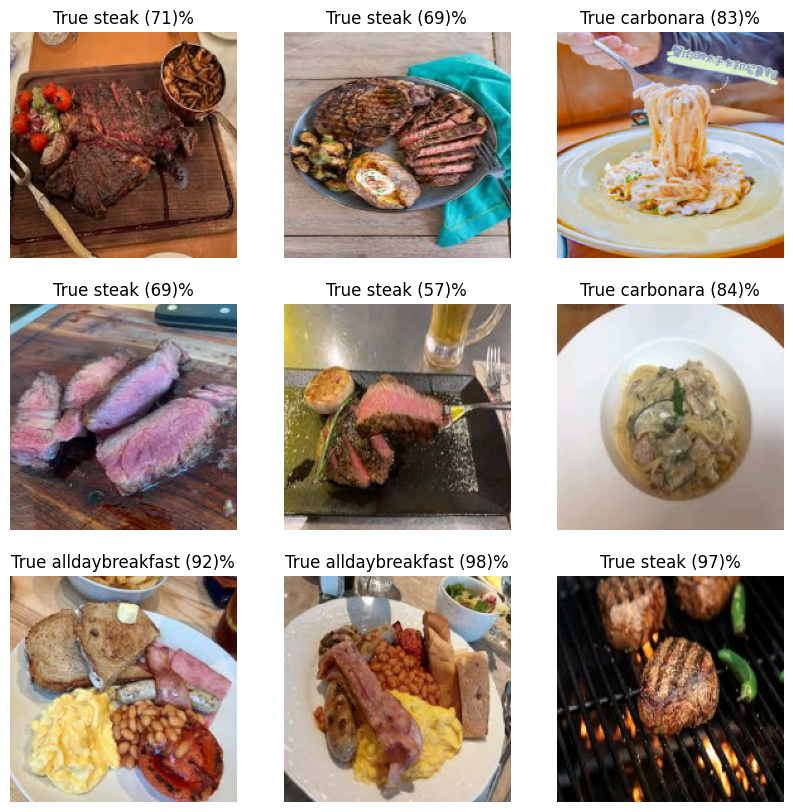

In [46]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        image = images[i]
        actual_label_index = int(labels[i])
        actual_label_name = class_names[actual_label_index]
        # print('actual_label_index:',actual_label_index)
        # print('actual_label_name:',actual_label_name)
        input = np.array(image)
        input = input.reshape((1,img_width,img_height,3))
        predictions = model(input, training=False)
        predictions = tf.nn.softmax(predictions[0])
        predict_index = np.argmax(predictions)
        predict_prob = np.max(predictions) * 100
        predict_label = class_names[predict_index]
        # print('predictions:', predictions)
        # print('predict_index:', predict_index)
        # print('predict_label:', predict_label)
        # print('predict_prob:', predict_prob)
        title = f"{actual_label_name} -> {predict_label} ({int(predict_prob)})%"
        title = f"{actual_label_name == predict_label} {predict_label} ({int(predict_prob)})%"
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(title)
        plt.axis("off")

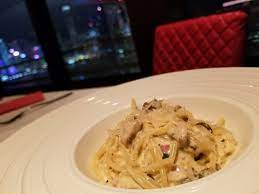

In [52]:
carbonara = tf.keras.utils.load_img("../keepfit/finailed-test-data/carbonara/06d4e0e28537a4afe99fd2b1a8dd1e637dc7aad01e6948256202526bd64c407b.jpeg")
carbonara_path = "../keepfit/finailed-test-data/steak/0d1936ba24cf5f63483e376c894d15fa13b4b771c4624b49d1b6941b5eca3349.jpeg"
carbonara

In [53]:
img = tf.keras.utils.load_img(
    carbonara_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to steak with a 99.87 percent confidence.


In [55]:
model.save('./model', overwrite=True)

INFO:tensorflow:Assets written to: ./foodRecognizeModel/assets


INFO:tensorflow:Assets written to: ./foodRecognizeModel/assets
